In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE

import tensorflow as tf
# from tensorflow.python import keras
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils import np_utils
# from tensorflow.python.keras import regularizers
# from tensorflow.python.keras.models import load_model

import matplotlib.pyplot as plt 
# from scipy.stats import norm

from pickle import dump

# from models import resnet
from models import transformer

In [2]:
# load data
data = pd.read_csv("../data/csv/data.csv", sep = ",")
print(data.dtypes)

race_id                        int64
race_round                     int64
ground_condition               int64
total_horse_number             int64
order                          int64
frame_number                   int64
horse_number                   int64
age                            int64
burden_weight                float64
goal_time                    float64
half_order                   float64
last_time                    float64
odds                         float64
pop                          float64
horse_weight                 float64
race_rank                      int64
distance                       int64
ground_type_ダ                  int64
ground_type_芝                  int64
circle_右                       int64
circle_左                       int64
weather_circumstance_小雨        int64
weather_circumstance_小雪        int64
weather_circumstance_晴         int64
weather_circumstance_曇         int64
weather_circumstance_雨         int64
weather_circumstance_雪         int64
p

In [3]:
# adjust columns type
data['race_id'] = data['race_id'].astype(str)
# data['race_round'] = data['race_round'].astype(str)
# #data['total_horse_number'] = data['total_horse_number'].astype(str)
data['order'] = data['order'].astype(str)
# data['frame_number'] = data['frame_number'].astype(str)
# data['horse_number'] = data['horse_number'].astype(str)


In [4]:
# delete race day information
data = data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1)
# "race_round",

In [5]:
# standarlization 
no_scale_data = data[['race_id','order']]
scale_columns = data.drop(['race_id','order'], axis=1).columns.values
standard_scale = StandardScaler()
data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))
data = pd.concat([data, no_scale_data], axis=1)
dump(standard_scale, open("standard_scale.pkl", "wb"))

In [6]:
# # creating time series data
# def return_one_race(all_horse):
#     print(len(all_horse))
#     one_race = np.full((18, 139), -float('inf'))
# #     print(len(one_race))
# #     print(len(one_race[0]))
#     for i, one_horse in all_horse.iterrows():
#         print(i)
# #         print(one_horse)
#         one_race[i] = one_horse.drop(['race_id']).values
#     print(one_race)
#     return one_race

# def create_time_series_data(raw_data):
#     time_series_data = []
#     time_series_data.append(raw_data.groupby(['race_id']).apply(return_one_race))
#     return time_series_data

In [7]:
print(data.shape)
print(data.dtypes)
print(data.head(15))

(92033, 142)
0          float64
1          float64
2          float64
3          float64
4          float64
5          float64
6          float64
7          float64
8          float64
9          float64
10         float64
11         float64
12         float64
13         float64
14         float64
15         float64
16         float64
17         float64
18         float64
19         float64
20         float64
21         float64
22         float64
23         float64
24         float64
25         float64
26         float64
27         float64
28         float64
29         float64
30         float64
31         float64
32         float64
33         float64
34         float64
35         float64
36         float64
37         float64
38         float64
39         float64
40         float64
41         float64
42         float64
43         float64
44         float64
45         float64
46         float64
47         float64
48         float64
49         float64
50         float64
51         float64

In [8]:
def create_time_series_data(raw_data):
    number_of_race = raw_data.race_id.nunique()
    time_series_data = np.full((number_of_race, 18, 140), -float('inf'))
    label = np.full((number_of_race, 18), 18)
    race_number = 0
    horse_number = 0
    for i in range(len(raw_data)):
        if i == 0:
            label[race_number][horse_number] = raw_data.iloc[i].order
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
            continue
        if data.iloc[i].race_id != data.iloc[i-1].race_id:
            race_number += 1
            horse_number = 0
            label[race_number][horse_number] = raw_data.iloc[i].order
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
        else:
            label[race_number][horse_number] = raw_data.iloc[i].order
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
    return time_series_data, label

In [9]:
X, y_order = create_time_series_data(data)
print(X.shape)
print(y_order.shape)

(8489, 18, 140)
(8489, 18)


In [10]:
print(X[0][11])
print(y_order[0])

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
[ 5  2 11  7  1  6  3  8  4 12 14 18 18 18 18 18 18 18]


In [11]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order)
print(y[0])
print(X.shape)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

AxesSubplot(0.125,0.125;0.775x0.755)


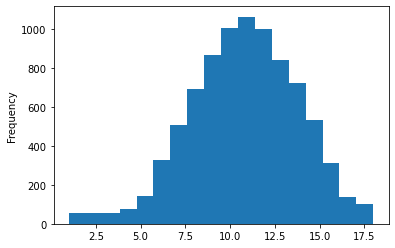

In [12]:
print(data.race_id.value_counts().plot.hist(bins=18,range=(1,18)))

AxesSubplot(0.125,0.125;0.775x0.755)


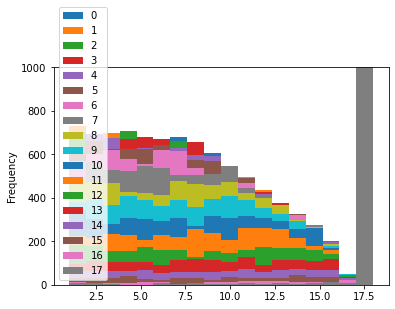

In [13]:
print(pd.DataFrame(y_order).plot.hist(bins=18, ylim=(0,1000)))

In [14]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
print(X_train[0][0])

[-1.31454307 -0.50991479  0.59013061  0.089023    0.36330459 -0.55563597
 -0.38537533  0.85504093 -0.77982377  0.77982377  0.67986075 -0.66338959
 -0.18337316 -0.02931084 -1.30912072  1.59720596 -0.2365526  -0.02236226
 -0.24513794  2.22552812 -0.4990219  -0.17550196 -0.22035921 -0.25591547
 -0.1797976  -0.49679594 -0.19606745 -0.4557965  -0.22428838 -0.71253043
  0.79060012 -1.15247676 -0.4643385  -1.24998201 -0.29165798 -0.1354737
 -0.29401694  0.58388887 -0.47249719  0.49675109 -1.33901568 -0.53560555
  0.61866615  0.98761696  0.8457565  -0.52081361  0.79192851 -1.09522929
  0.4266353   1.66401254 -0.18337316 -0.03058303 -1.30378873  1.59386688
 -0.23864526 -0.02422995 -0.1135239  -0.25064443  2.28503578 -0.48723901
 -0.18498134 -0.24115274 -0.26462566 -0.18406838 -0.47511456 -0.2061855
 -0.44352027 -0.37101354 -0.78900406  0.79361561 -0.0526072   0.20228021
 -0.68588199 -0.52846843 -0.49079906 -0.64001629  1.00592424  1.36893206
 -0.52115315  1.29058557 -1.24905804  0.10102149  1.6

In [16]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6791, 18, 140)
(1698, 18, 140)
(6791, 18, 19)
(1698, 18, 19)


In [17]:
# set up parameters
num_layers = 4
d_model = 140
num_heads = 4
d_ffn = 512
pe_input = 18
target_size = 19
dropout_rate = 0.1

In [18]:
# set up model
trans_race = transformer.TransRace(
                num_layers=num_layers,
                d_model=d_model,
                num_heads=num_heads,
                d_ffn=d_ffn,
                pe_input=pe_input,
                target_size=target_size,
                rate=dropout_rate)

# trans_race.build(input_shape=(None,18,139))
trans_race.compile(
            optimizer='adam',
            loss='crossentropy',
            metrics=['accuracy'],
            )

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [19]:
history = trans_race.fit(
                        [X_train, y_train],
                        validation_data=([X_valid, y_valid]),
                        batch_size=512,
                        epochs=100,
                        callbacks=[early_stopping],
#                         verbose=0, # hide the output because we have so many epochs
                        )
trans_race.save_weights("../models/results/transfomer1.h5")

ValueError: in converted code:

    /mnt/c/Users/44yos/RacePrediction/resnet_win5/models/transformer.py:194 call  *
        enc_padding_mask = self.create_masks(inp) #, tar
    /mnt/c/Users/44yos/RacePrediction/resnet_win5/models/transformer.py:205 create_masks  *
        enc_padding_mask = create_padding_mask(inp)
    /mnt/c/Users/44yos/RacePrediction/resnet_win5/models/transformer.py:29 create_padding_mask  *
        return seq[:, tf.newaxis, tf.newaxis, seq_len]  # (batch_size, 1, 1, seq_len)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:802 _slice_helper
        name=name)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:968 strided_slice
        shrink_axis_mask=shrink_axis_mask)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py:10392 strided_slice
        shrink_axis_mask=shrink_axis_mask, name=name)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:794 _apply_op_helper
        op_def=op_def)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:3371 create_op
        attrs, op_def, compute_device)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:3440 _create_op_internal
        op_def=op_def)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1784 __init__
        control_input_ops)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1624 _create_c_op
        raise ValueError(str(e))

    ValueError: slice index 18 of dimension 1 out of bounds. for 'trans_race/strided_slice' (op: 'StridedSlice') with input shapes: [?,18,140], [4], [4], [4] and with computed input tensors: input[1] = <0 0 0 18>, input[2] = <0 0 0 19>, input[3] = <1 1 1 1>.


In [ ]:
trans_race.summary()

In [ ]:
# OWN_FILE_NAME = path.splitext(path.basename('\\Users\\vmlab\\win5.ext'))[0]

model = resnet.ResRace(X_train.shape[1], Y_train.shape[1])

# class_weights = {0:13,
#                 1:13,
#                 2:13,
#                 3:13,
#                 4:14,
#                 5:14,
#                 6:14,
#                 7:14,
#                 8:14,
#                 9:15,
#                 10:15,
#                 11:16,
#                 12:18,
#                 13:20,
#                 14:23,
#                 15:28,
#                 16:36,
#                 17:159,
#                 18:215}
history = model.fit(X_train, Y_train, batch_size = 2048, epochs = 100, validation_split = 0.1) #class_weight = class_weights
# tmpdir = tempfile.mkdtemp()
# model_path = os.path.join(tmpdir, "/model/win5_resrace_model/")
# tf.saved_model.save(model, model_path)
model.save_weights("../models/results/transfomer1.h5")

In [21]:
# predict

pred = model.predict(X_test)
pred_order = np.argmax(pred, axis = 1)
Y_ans = np.argmax(Y_test, axis = 1)


In [22]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


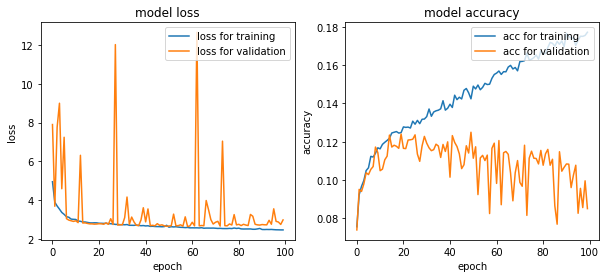

In [23]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='upper right')
# figureの保存
plt.savefig("../models/results/result.png")

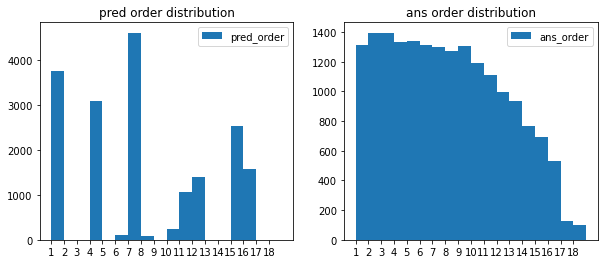

In [12]:
# 何位に予想した？　何位が含まれていた？
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']

axL.hist(pred_order, bins = 18, label = "pred_order", range = (1,19))
axL.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(Y_ans, bins = 18, label = "ans_order", range = (1,19))
axR.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [12]:
# print(np.unique(pred_order))
# print(np.unique(Y_ans))
# u, c = np.unique(pred_order, return_counts = True)
# print(u)
# print(c)

all_f:  6950
correct_first:  1045
hit odds average:  6.190526315789473
spent money: 695000
retrive rate:  0.9308057553956829
revenue:  -48090.00000000042
accuracy:  0.15035971223021583
min:  1.1000000000000014
mid:  4.600000000000001
max:  46.3


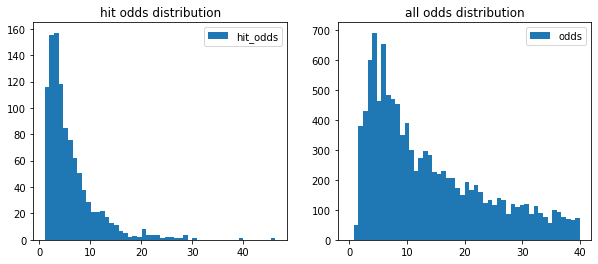

In [13]:
# accuracy of the first horse
i = 0
correct_first = 0
all_f = 0
increase = 0
X_test_inv = standard_scale.inverse_transform(X_test)
X_test_inv_df = pd.DataFrame(X_test_inv)
odds = X_test_inv_df[4].values
hit_odds = []
select = []

for i in range(len(Y_ans)):
    if (pred_order[i] == 1):  # いちい予想した総数  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
        all_f = all_f + 1
        if (Y_ans[i] == 1):
            correct_first = correct_first + 1   #　一致した総数
            increase += odds[i]
            hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
print("hit odds average: ", np.array(hit_odds).mean())
print("spent money:", all_f * 100)
revenue = (increase - all_f) * 100
retrive = increase / all_f
 
print("retrive rate: ", retrive) 
print("revenue: ", revenue)
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
#print("\n".join(map(str,hit_odds)))
print("min: ", min(hit_odds))
print("mid: ", np.median(np.array(hit_odds)))
print("max: ", max(hit_odds))

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.hist(hit_odds, bins = 50, label = "hit_odds")
axL.set_title('hit odds distribution')
axL.legend()
axR.hist(odds, bins = 50, label = "odds", range = (0,40))
axR.set_title('all odds distribution')
axR.legend()
fig.show()


accuracy:  0.19058823529411764
all_f_odds average:  11.4


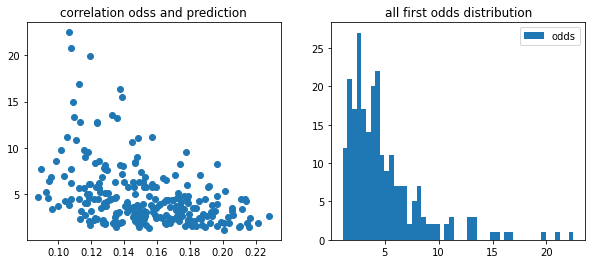

In [62]:
# 一位だった時一位予想していた確率
i = 0
correct_first = 0
all_f = 0
odds_f = []
p_rate_f = []

all_f_odds = []

for i in range(len(Y_ans)):
    if (Y_ans[i] == 1):  # 一位の総数
        all_f = all_f + 1
        all_f_odds.append(odds[i])
        if (pred_order[i] == 1):
            correct_first = correct_first + 1   #　一致した総数
            odds_f.append(odds[i])
            p_rate_f.append(pred[i][1])

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.scatter(p_rate_f, odds_f)  
axL.set_title('correlation odss and prediction')
#axL.xlabel('prediction rate first')
#axL.ylabel('odds')
axR.hist(odds_f, bins = 50, label = "odds")
axR.set_title('all first odds distribution')
axR.legend()

fig.show()
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
print("all_f_odds average: ", np.array(all_f_odds).mean())



ensamble log

In [43]:
model1 = resnet.resrace(X_test.shape[1], 19)
model1.load_weights("model/win5_resrace_model_best1.h5")
pred1 = model1.predict(X_test)

In [44]:
model2 = resnet.resrace(X_test.shape[1], 19)
model2.load_weights("model/win5_resrace_model_best2.h5")
pred2 = model2.predict(X_test)

In [45]:
model3 = resnet.resrace(X_test.shape[1], 19)
model3.load_weights("model/win5_resrace_model_best3.h5")
pred3 = model3.predict(X_test)

In [46]:
model4 = resnet.resrace(X_test.shape[1], 19)
model4.load_weights("model/win5_resrace_model_best4.h5")
pred4 = model4.predict(X_test)

In [47]:
model5 = resnet.resrace(X_test.shape[1], 19)
model5.load_weights("model/win5_resrace_model_best5.h5")
pred5 = model5.predict(X_test)

In [48]:
model6 = resnet.resrace(X_test.shape[1], 19)
model6.load_weights("model/win5_resrace_model_best6.h5")
pred6 = model6.predict(X_test)

In [49]:
model7 = resnet.resrace(X_test.shape[1], 19)
model7.load_weights("model/win5_resrace_model_best7.h5")
pred7 = model7.predict(X_test)

In [50]:
model8 = resnet.resrace(X_test.shape[1], 19)
model8.load_weights("model/win5_resrace_model_best8.h5")
pred8 = model8.predict(X_test)

In [51]:
model9 = resnet.resrace(X_test.shape[1], 19)
model9.load_weights("model/win5_resrace_model_best9.h5")
pred9 = model9.predict(X_test)

In [52]:
model10 = resnet.resrace(X_test.shape[1], 19)
model10.load_weights("model/win5_resrace_model_best10.h5")
pred10 = model10.predict(X_test)

In [58]:
log_pred1 = np.log(pred1)
log_pred2 = np.log(pred2)
log_pred3 = np.log(pred3)
log_pred4 = np.log(pred4)
log_pred5 = np.log(pred5)
# log_pred6 = np.log(pred6)
# log_pred7 = np.log(pred7)
# log_pred8 = np.log(pred8)
# log_pred9 = np.log(pred9)
# log_pred10 = np.log(pred10)

sum_pred = log_pred1 + log_pred2 + log_pred3 + log_pred4 + log_pred5 #+ log_pred6 + log_pred7 + log_pred8 + log_pred9 + log_pred10
pred_order = np.argmax(sum_pred, axis = 1)

In [24]:
# print(sum_pred[:5])

[[ -92.500374   -20.10813    -17.505821   -16.513687   -14.976219
   -14.493359   -13.222591   -12.886332   -12.512679   -12.478747
   -11.932049   -12.158701   -12.034502   -12.656912   -14.057566
   -16.038065   -18.60048    -33.052044   -37.144245 ]
 [-148.93903    -16.659998   -13.859893   -13.222133   -11.323556
   -11.52779    -10.4130335  -10.327539   -10.932216   -11.930389
   -12.92849    -15.504711   -18.608528   -23.14984    -28.117496
   -32.706753   -37.238995   -61.38399    -67.225845 ]
 [-106.79495    -18.205135   -15.62729    -14.748198   -13.11282
   -12.945486   -11.783406   -11.413827   -11.453916   -11.632684
   -11.572009   -12.674328   -13.867571   -16.293985   -19.358545
   -22.550428   -26.093182   -42.98315    -47.908054 ]
 [-148.91325     -7.0621834   -7.6713886   -9.898946   -11.581405
   -13.209185   -14.140819   -15.5365305  -16.885832   -18.269995
   -20.148869   -22.154903   -24.924255   -27.35007    -29.743752
   -33.128033   -36.03937    -57.0517     -5

In [25]:
# print(pred_order[:5])

[10  7  7  1 10]
